In [83]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

In [68]:
df = pd.read_csv('bank-full.csv', sep=';')

In [69]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [70]:
categorical_vals

['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [71]:
numerical_vals

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'y']

In [72]:
df.y=(df.y=='yes').astype(int)

In [73]:
df=df[['age','job','marital','education','balance','housing','contact','day','month','duration','campaign','pdays','previous','poutcome','y']]
df_full_train,df_test=train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val=train_test_split(df_full_train,test_size=0.25,random_state=1)
del(df_full_train)

In [74]:
df_train_numerical = df_train.select_dtypes(include='number')
df_train_categorical = df_train.select_dtypes(exclude='number')
categorical_vals=list(df_train_categorical.columns)
numerical_vals=list(df_train_numerical.columns)

In [75]:
#Q1
df_test_auc = df_train_numerical.copy()
features=list(df_test_auc.columns)
features.remove('y')
for feature in features:
    if roc_auc_score(df['y'],df[feature]) < 0.5: 
        print ('%s %.3f' % (feature, roc_auc_score(df['y'],-df[feature])))
    else:
        print ('%s %.3f' % (feature, roc_auc_score(df['y'],df[feature])))

age 0.508
balance 0.590
day 0.527
duration 0.808
campaign 0.572
pdays 0.593
previous 0.602


In [76]:
#Q2
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse = False)

train_dict = df_train[categorical_vals].to_dict(orient = 'records')
y_train = df_train.y.values
#del df_train['y']
X_train = dv.fit_transform(train_dict)

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver = 'liblinear', C = 1.0, max_iter = 1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [77]:
val_dict = df_val[categorical_vals].to_dict(orient = 'records')
y_val = df_val.y.values
#del df_val['y']
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred).round(3)

0.768

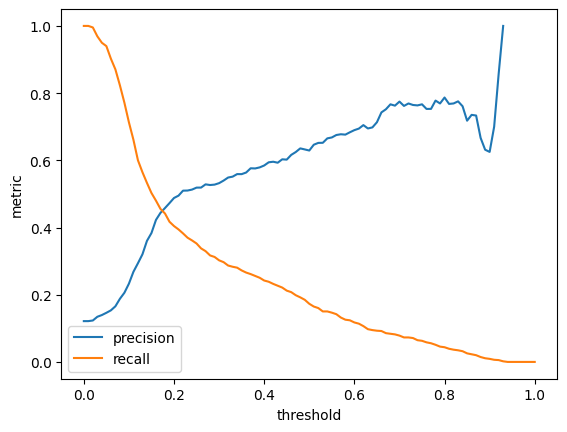

In [79]:
scores = []
thresholds = np.linspace(0,1,101)

for t in thresholds: 
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred <= t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    if tp+fp==0:
        p=np.nan
    else:
        p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    scores.append((t, p, r))
    
columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns = columns)

plt.plot(df_scores.threshold,df_scores.precision, label = 'precision')
plt.plot(df_scores.threshold,df_scores.recall, label = 'recall')
plt.xlabel('threshold')
plt.ylabel('metric')
plt.legend()

In [81]:
scores = []
thresholds = np.linspace(0,1,101)

for t in thresholds: 
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred <= t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    if tp+fp==0:
        p=np.nan
    else:
        p = tp / (tp + fp)
    r = tp / (tp + fn)
    r = tp / (tp + fn)
    f1_score = 2 * ((p * r) / (p + r))
    
    scores.append((t, p, r, f1_score))

columns = ['threshold', 'precision', 'recall', 'f1_score']
df_scores = pd.DataFrame(scores, columns = columns)

max_f1_score = df_scores['f1_score'].max()
print(max_f1_score)
df_scores[df_scores['f1_score'] == max_f1_score].threshold

0.44969865554010197


18    0.18
Name: threshold, dtype: float64

In [87]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_vals].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver = 'liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [88]:
def predict(df, dv, model):
    dicts = df[categorical_vals].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [92]:
from sklearn.model_selection import KFold 

kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)
scores = []

for train_idx, val_idx in kfold.split(df_train):
    df_train = df.iloc[train_idx]
    df_val = df.iloc[val_idx]
    
    y_train = df_train.y.values
    y_val = df_val.y.values
    
    dv, model = train(df_train, y_train, C = 1)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    
std = np.array(scores).std()
std

0.01647728785599371

In [93]:
n_splits = 5

for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_train):
        # the k-fold split uses index to shuffle the data
        df_train = df.iloc[train_idx]
        df_val = df.iloc[val_idx]
        
        # y values come from dataset
        y_train = df_train.y.values
        y_val = df_val.y.values
        
        # training and predicting
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        # AUC
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print('C= %s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C= 1e-06 0.580 +- 0.018
C= 0.001 0.567 +- 0.011
C= 1 0.580 +- 0.014
